In [1]:
!pip install -U fiona shapely pyproj rtree

!pip install -U geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.5 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalled geopandas-0.13.2


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import json

import matplotlib.pyplot as plt

In [6]:
colonias = gpd.read_file('zip:///content/drive/MyDrive/Colonias CDMX/data/espacial/colonias_seduvi.zip').drop(columns=['pob_2010','area','perimetro','cve_ent'])
#colonias.geometry = colonias.geometry.buffer(0)

In [7]:
areas_verdes =  gpd.read_file('zip:///content/drive/MyDrive/Colonias CDMX/data/variables/areas_verdes_cdmx.zip',
                              econding='latin1').to_crs(colonias.crs)

areas_verdes.geometry = areas_verdes.geometry.buffer(0)

areas_verdes['area_tot'] = areas_verdes.area

In [8]:
cols_verdes = colonias.overlay(areas_verdes, make_valid=True, how='intersection')
cols_verdes['area'] = cols_verdes.area
cols_verdes['cnt'] = 1
cols_verdes['cnt_relativo'] = [row.area/row.area_tot for row in cols_verdes.itertuples()]

In [9]:
cols_verder_join = cols_verdes.groupby(['cve_col','colonia','categoria_']).area.sum().unstack().reset_index().fillna(0)
cols_verder_join['area_total'] = cols_verder_join.sum(axis=1, numeric_only=True)
cols_verder_join = gpd.GeoDataFrame(pd.merge(cols_verder_join, colonias, on=['cve_col', 'colonia']))
cols_verder_join['area_rel_col'] = 100*cols_verder_join.area_total/cols_verder_join.area

cols_verder_join = cols_verder_join.round(3)

## ¿Cómo puedo definir una variable que me diga el aporte de area verde a toda la ciudad?

In [10]:
cols_verder_join

,cve_col,colonia,Equipamientos urbanos con vegetación,Forestación urbana,"Parques, arboledas y alamedas",Plazas y jardines,Vivero,Áreas con características de protección,Áreas con categoría de protección,Áreas con vegetación reminisciente,Áreas verdes complementarias o ligadas a la red vial,Áreas verdes con estructura urbana,Áreas verdes urbanas fragmentadas,area_total,alcaldia,geometry,area_rel_col
0,02-001,AGUILERA,0.000,0.0,4713.583,0.000,0.0,0.0,0.0,0.0,884.565,0.0,0.000,5598.148,AZCAPOTZALCO,"POLYGON ((483311.618 2153254.848, 483332.006 2...",5.392
1,02-002,ALDANA,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,3521.142,0.0,0.000,3521.142,AZCAPOTZALCO,"POLYGON ((484406.956 2153012.331, 484401.132 2...",2.274
2,02-003,PETROLERA (AMPL),0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,6868.264,0.0,0.000,6868.264,AZCAPOTZALCO,"POLYGON ((479361.336 2154537.765, 479378.533 2...",5.056
3,02-005,ANGEL ZIMBRON,2026.053,0.0,0.000,0.000,0.0,0.0,0.0,0.0,12848.651,0.0,1938.516,16813.220,AZCAPOTZALCO,"POLYGON ((480275.324 2152244.351, 480267.968 2...",6.941
4,02-006,ARENAL,0.000,0.0,693.796,0.000,0.0,0.0,0.0,0.0,3810.654,0.0,0.000,4504.450,AZCAPOTZALCO,"POLYGON ((484061.118 2152622.284, 484061.678 2...",1.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,17-082,MOCTEZUMA 2A SECCION IV,10785.611,0.0,0.000,2021.069,0.0,0.0,0.0,0.0,9205.862,0.0,0.000,22012.541,VENUSTIANO CARRANZA,"POLYGON ((489540.363 2148472.511, 489650.894 2...",4.279
1383,17-083,MORELOS I,3958.804,0.0,7011.942,0.000,0.0,0.0,0.0,0.0,2565.744,0.0,0.000,13536.490,VENUSTIANO CARRANZA,"POLYGON ((487005.967 2149240.615, 487024.199 2...",2.999
1384,17-084,MORELOS II,2764.793,0.0,9457.217,1317.536,0.0,0.0,0.0,0.0,5337.054,0.0,0.000,18876.601,VENUSTIANO CARRANZA,"POLYGON ((487277.125 2150400.449, 487374.774 2...",3.831
1385,17-085,PENSADOR MEXICANO I,130855.330,0.0,6486.879,2420.232,0.0,0.0,0.0,0.0,8510.489,0.0,0.000,148272.931,VENUSTIANO CARRANZA,"POLYGON ((491930.096 2150542.935, 491946.526 2...",25.027


In [11]:
cols_verdes_cnt = cols_verdes.groupby(['cve_col','colonia'])[['cnt','cnt_relativo']].sum().reset_index().fillna(0).round(2)

In [12]:
cols_verdes_final = gpd.GeoDataFrame(pd.merge(cols_verder_join, cols_verdes_cnt, on=['cve_col','colonia']))

In [13]:
new_columns = {
    'Equipamientos urbanos con vegetación': 'EquiU',
    'Forestación urbana': 'ForUrb',
    'Parques, arboledas y alamedas': 'ParqA',
    'Plazas y jardines': 'PylJ',
    'Vivero': 'Viv',
    'Áreas con características de protección': 'ACCarProt',
    'Áreas con categoría de protección': 'ACProt',
    'Áreas con vegetación reminisciente': 'AVRem',
    'Áreas verdes complementarias o ligadas a la red vial': 'AVCom',
    'Áreas verdes con estructura urbana': 'AVCEU',
    'Áreas verdes urbanas fragmentadas': 'AVUFra'
}

In [14]:
def guardar_json(dictionary, path):
    json_object = json.dumps(dictionary, indent=4,
                             ensure_ascii=False)


    with open(path, "w") as outfile:
        outfile.write(json_object)

In [15]:
guardar_json(new_columns,"/content/drive/MyDrive/Colonias CDMX/areas_verdes/area_verde_original/diccionario_variables.json" )

In [16]:
cols_verdes_final.rename(columns=new_columns, inplace=True)

In [17]:
cols_verdes_final = pd.concat([cols_verdes_final,
                                colonias[~(colonias.cve_col.isin(cols_verdes_final.cve_col))]],
                                ignore_index=True
                                ).fillna(0)

In [ ]:
cols_verdes_final.to_file("/content/drive/MyDrive/Colonias CDMX/areas_verdes/resultado/areas_verdes_cdmx.shp",
                          index=False, encoding='UTF-8')


<ipython-input-22-29109c7d4368>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  cols_verdes_final.to_file("/content/drive/MyDrive/Colonias CDMX/areas_verdes/resultado/areas_verdes_cdmx.shp",


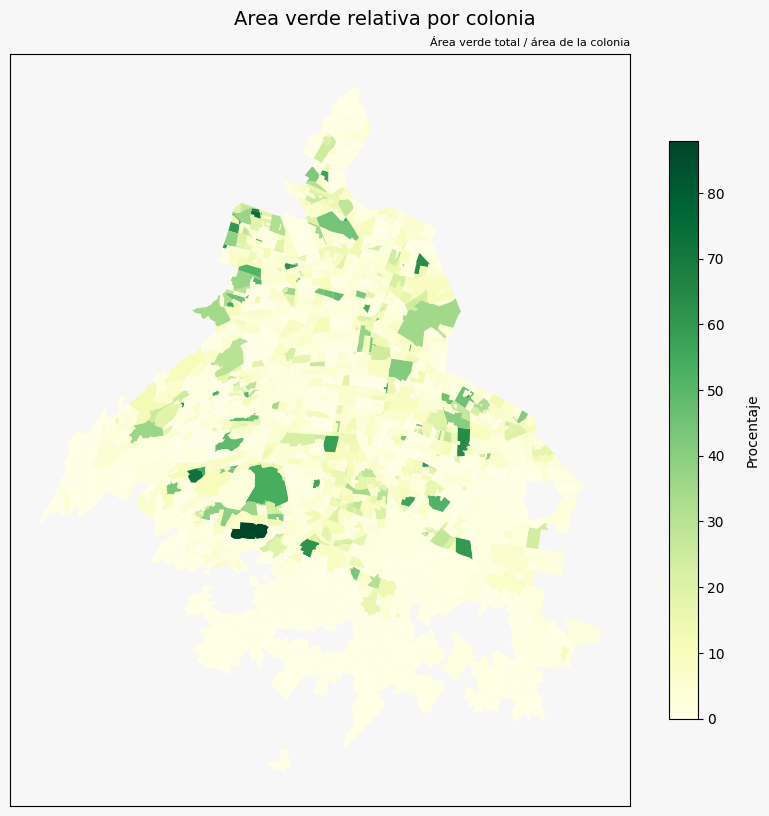

In [18]:
fig = plt.figure(figsize=(10, 15))

ax = cols_verdes_final.plot(column="area_rel_col", ax=plt.gca(),
                             cmap='YlGn', legend=True,
                             legend_kwds={"shrink": 0.5},# vmax=20000
                         )


#metro.plot(ax=ax, color='azure', markersize=15, ec='maroon')


color_fondo = '#f7f7f7'
ax.set_facecolor(color_fondo)
fig.patch.set_facecolor(color_fondo)


ax.set_xticks([])
ax.set_yticks([])

plt.suptitle("Area verde relativa por colonia", y=0.775, fontsize=14)
plt.title('Área verde total / área de la colonia', loc='right', fontsize=8)

cax = ax.get_figure().get_axes()[1]
cax.set_ylabel('Procentaje', rotation=90, labelpad=15)

# Guardar el gráfico como una imagen (esta línea está comentada)
plt.savefig('/content/drive/MyDrive/Colonias CDMX/areas_verdes/area_verde_original/mapa_area_verde.png', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()